# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
# !pip install numpy pandas matplotlib seaborn scikit-learn scipy -q

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from scipy import stats

from sklearn.model_selection   import train_test_split

from sklearn.preprocessing     import StandardScaler, MinMaxScaler, RobustScaler

from sklearn.metrics           import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model      import LinearRegression

from sklearn.pipeline          import Pipeline
from sklearn.compose           import ColumnTransformer

In [3]:
RANDOM_STATE = 1000

### Здесь будем хранить функции, которые будут использованы по ходу работы

In [4]:
# функция для просмотра основной информации датафреймов, провери пропущенных значений и наличия явных дубликатов 
def data_overview(**dfs):
    for name, df in dfs.items():
        print('Информация по таблице', name)
        display(df.head(5))
        print('Количество пропусков в таблице:', df.isna().sum().sum())
        dups = df.duplicated().sum().sum()
        print('Количество явных дубликатов в таблице:', dups)
        print(df.info(), '\n\n', f'Информация о распределении данных таблицы {name}')
        display(df.describe())

# Функция вывода результатов обучения модели
def fit_model_result(df, model=LinearRegression(), valid_size=0.25):
    X = df.drop(['id', 'product'], axis=1)
    y = df['product']
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=valid_size, random_state=RANDOM_STATE)

    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)

    metrics = pd.DataFrame({
        'Metric': ['R2', 'Средний pred запас', 'RMSE'],
        'Value': [r2_score(y_valid, y_pred), 
                  y_pred.mean(),
                  root_mean_squared_error(y_valid, y_pred)]})

    weights = pd.DataFrame({
        'Feature':X_train.columns,
        'Weight':[f"{i:+.2f}" for i in model.coef_]
    })

    data_dict = {'X_train':X_train, 
                 'X_valid':X_valid, 
                 'y_train':y_train, 
                 'y_valid':y_valid}
    
    display(metrics)
    display(weights)
    
    return model, y_pred, data_dict

# Функция для подсчета суммы прибыли с указанного количества скважин
def income_counter(df, y_name, y_pred_name, best_well):
    df_filtered = df.loc[:, [y_name, y_pred_name]]
    if df_filtered.shape[0] < best_well:
        return print('Ошибка размерности!')
    df_filtered.sort_values(by=y_pred_name, inplace=True, ascending=False)
    income = df_filtered[y_name].iloc[:best_well].sum() * 1000 * BARREL_REVENUE
    return income

Описание данных:
* id — уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
* product — объём запасов в скважине (тыс. баррелей).

In [5]:
try:
    geo_data_0 = pd.read_csv('geo_data_0.csv')
    geo_data_1 = pd.read_csv('geo_data_1.csv')
    geo_data_2 = pd.read_csv('geo_data_2.csv')
except:
    geo_data_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
    geo_data_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
    geo_data_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')  

После импорта таблиц посмотри на них и ознакомимся с основной информацией о размерности, пропусках и дубликатах.

In [6]:
data_overview(geo_data_0=geo_data_0, 
              geo_data_1=geo_data_1, 
              geo_data_2=geo_data_2
             )

Информация по таблице geo_data_0


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Количество пропусков в таблице: 0
Количество явных дубликатов в таблице: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None 

 Информация о распределении данных таблицы geo_data_0


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


Информация по таблице geo_data_1


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


Количество пропусков в таблице: 0
Количество явных дубликатов в таблице: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None 

 Информация о распределении данных таблицы geo_data_1


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


Информация по таблице geo_data_2


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Количество пропусков в таблице: 0
Количество явных дубликатов в таблице: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None 

 Информация о распределении данных таблицы geo_data_2


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [7]:
for name, df in {'geo_data_0':geo_data_0, 'geo_data_1':geo_data_1, 'geo_data_2':geo_data_2}.items():
    cnt = df.drop('id', axis=1).duplicated().sum()
    print(f"Количество добликтов в таблице {name} после удаления признака 'id':{cnt}")

Количество добликтов в таблице geo_data_0 после удаления признака 'id':0
Количество добликтов в таблице geo_data_1 после удаления признака 'id':0
Количество добликтов в таблице geo_data_2 после удаления признака 'id':0


Прверим каждый регион на уникальность встречающихся в нем скважин. Для этого объедеиним все столбцы с признаком id и посмотрим есть ли дублирующиеся.

In [8]:
all_ids = pd.concat([geo_data_0['id'], geo_data_1['id'], geo_data_2['id']], axis=0)
all_ids.duplicated().sum()

49

Оказалось есть 49 скважин, которые присутствуют более чем в одном регионе. В идеале, если есть такая возможность, лучше доподленно уточнить их происхождение и отнести их к правильному региону. Однако, в ситуации когда таких скважин много, а количество дубликатов незначительно, проще просто избавиться от скважин с неопределенным регионом.

In [9]:
not_unique_wells = all_ids[all_ids.duplicated()].unique()

In [10]:
geo_data_0 = geo_data_0[~geo_data_0['id'].isin(not_unique_wells)].reset_index(drop=True)
geo_data_1 = geo_data_1[~geo_data_1['id'].isin(not_unique_wells)].reset_index(drop=True)
geo_data_2 = geo_data_2[~geo_data_2['id'].isin(not_unique_wells)].reset_index(drop=True)

После предварительного знакомства с данными можно отметить отсутствие пропущенных значений и явных дубликатов. Это значительно упрощает нам жизнь. Наимнование столбцов соответствует общепринятым нормам. Неоригинальные скважины удалены. Перед началом работы с моделью хочется посмотреть на распределение признаков и проверить их на мультиколлинеарность с целевым.

Входных признаков не много, что позволит нам посмотреть на распеределение и зависимость каждой величины с помощью `sns.PairGrid()`

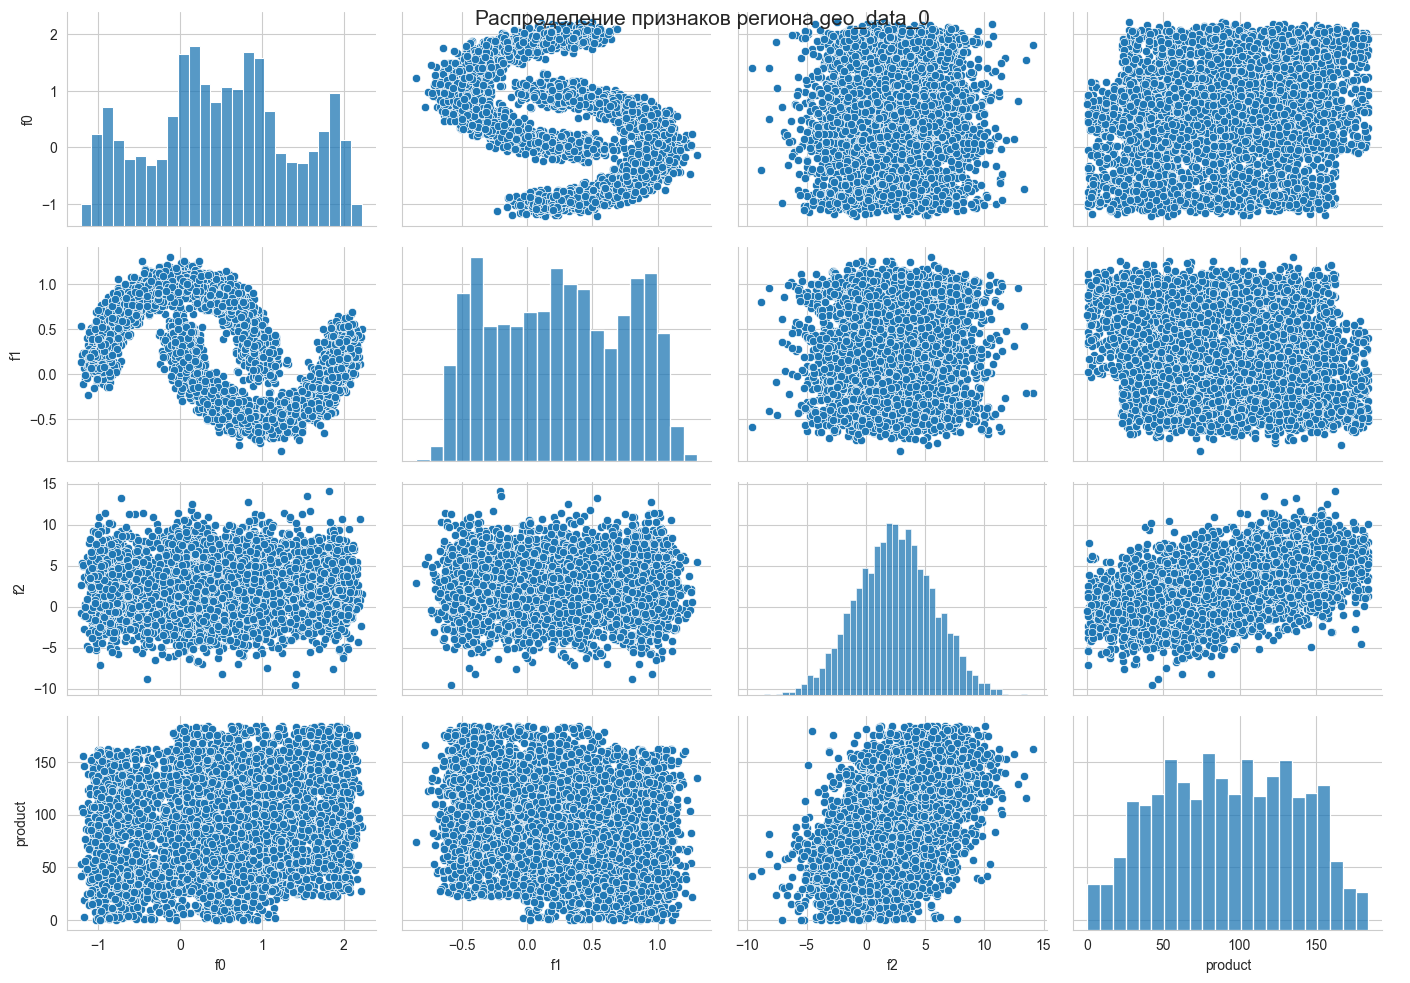

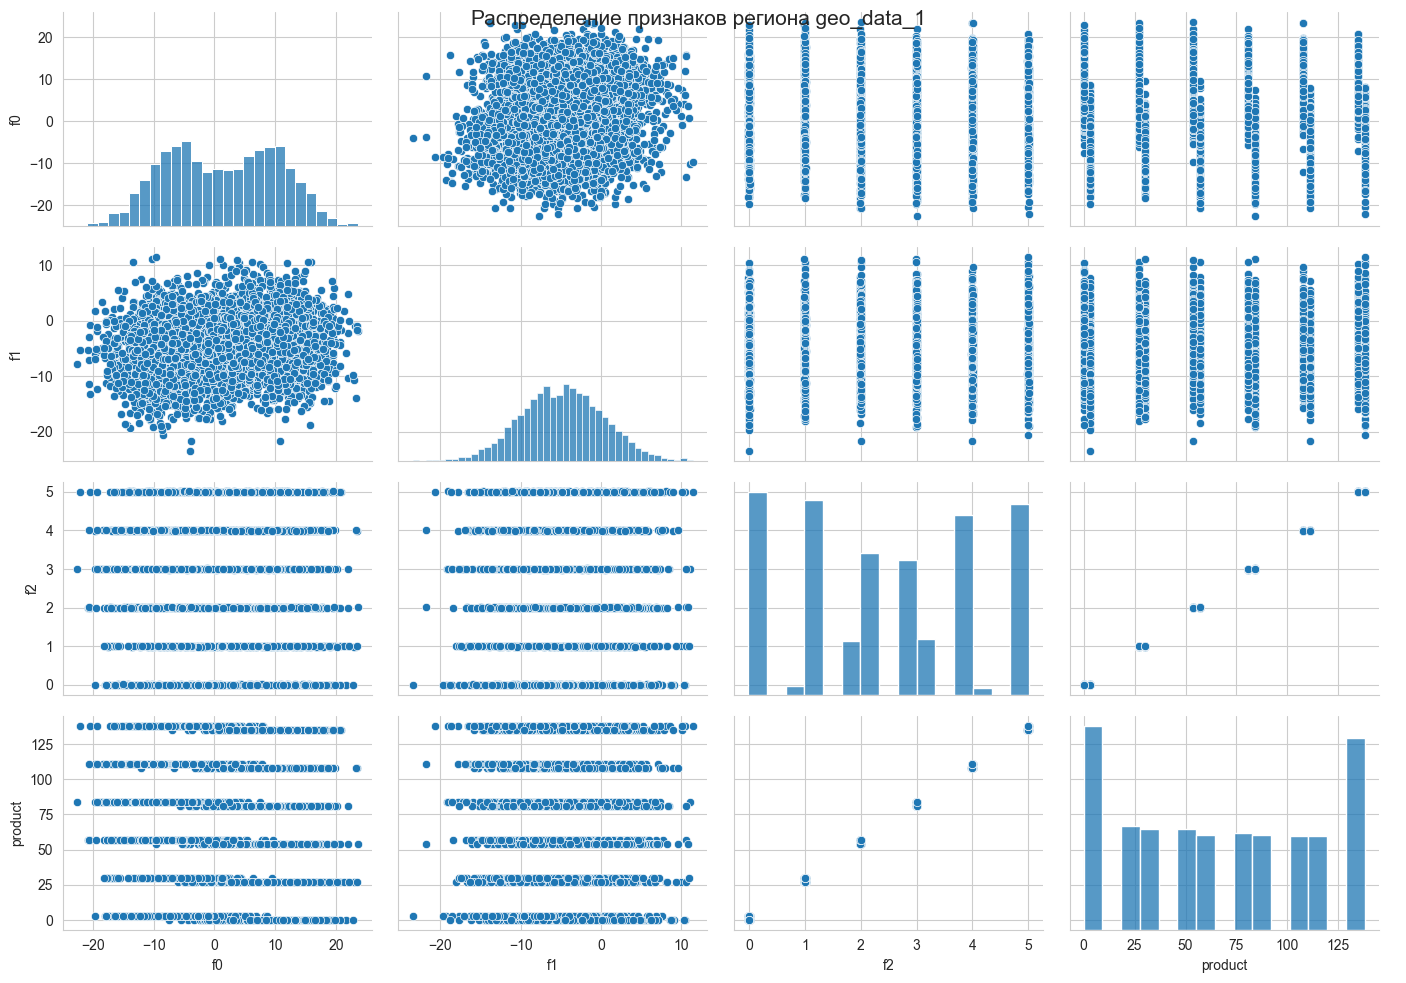

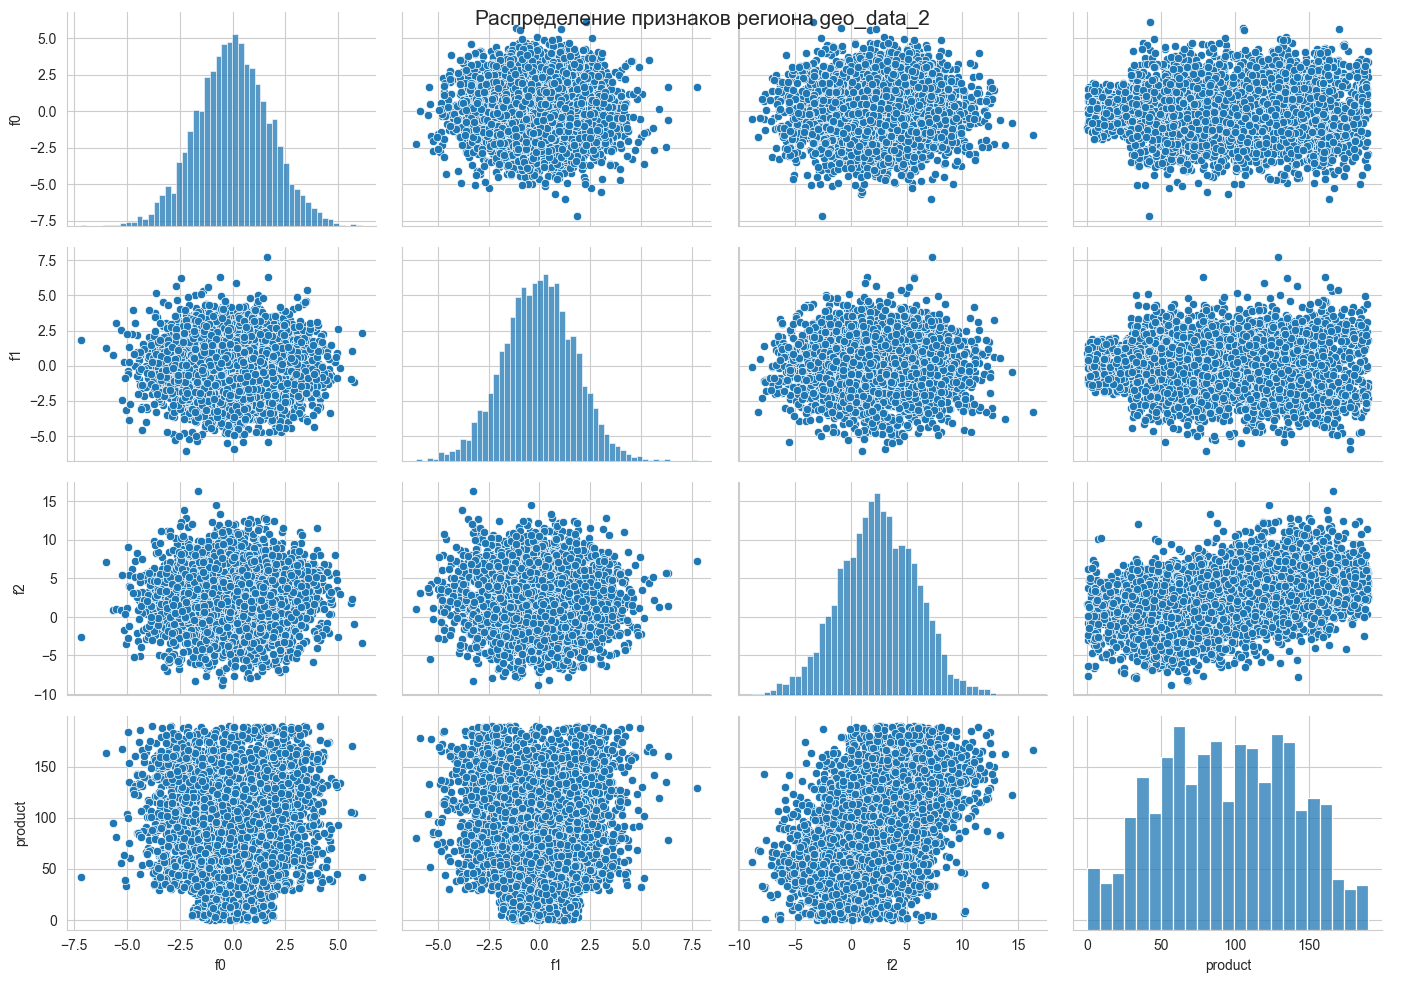

In [11]:
for name, df in {'geo_data_0':geo_data_0, 'geo_data_1':geo_data_1, 'geo_data_2':geo_data_2}.items():
    g = sns.PairGrid(df.sample(5000, random_state=RANDOM_STATE), aspect=1.4)
    g.map_diag(sns.histplot)
    g.map_offdiag(sns.scatterplot)
    g.add_legend()
    fig = plt.gcf()
    fig.suptitle(f'Распределение признаков региона {name}\n', fontsize=15)


plt.show()

Нормальное распределение входных признаков присутствует, но не для всех и не во всех регионах. Так в регионе geo_data_1 признак значения признака f2 близки к дискретным, аналогично целевой признак product можно сгруппировать по категориям. В регионе регионе geo_data_2 данные распределены нормально, а вот в регионе geo_data_0 признакам f1 и f0 присуща мультимодальность.

Сразу можно обратить внимание на зависимость между f2 и product в 1 регионе.

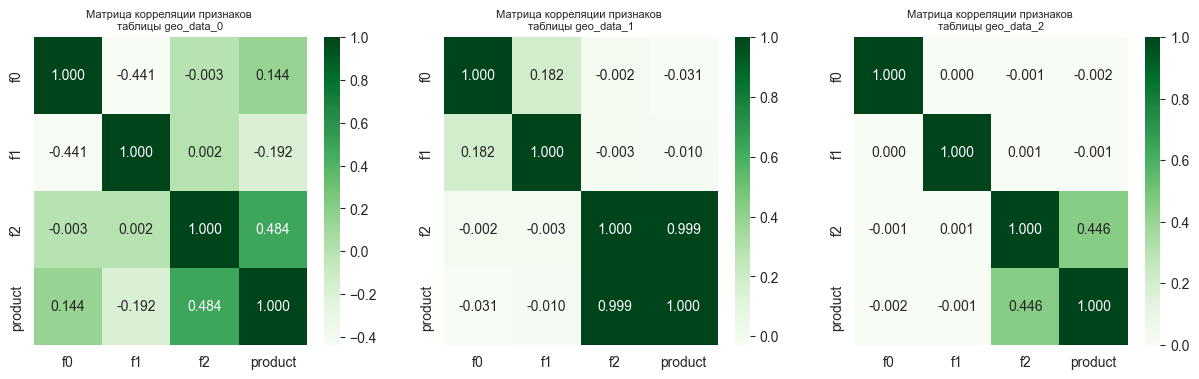

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
cnt = 0
for name, df in {'geo_data_0':geo_data_0, 'geo_data_1':geo_data_1, 'geo_data_2':geo_data_2}.items():
    ax = axs[cnt]
    sns.heatmap(df.drop('id', axis=1).corr(), annot=True, cmap='Greens', fmt=".3f", ax=ax)
    ax.set_title(f'Матрица корреляции признаков \nтаблицы {name}', fontsize=8)
    cnt += 1
plt.show()  

В ТЗ сказано что для решения задачи необходимо использовать только линейную регрессию. Я еще не знаю (пока что) в каком регионе скважины производительне, но точно могу отметить что линейная регрессия справится лучше с данными таблицы geo_data_1, присутствует очень сильная линейная взамосвязь между f2 и целевым признаком product. В датафрейме geo_data_2 ситуация похожа, только "степень" линейной зависимости слабее. В таблице geo_data_1 модель будет опираться только на один входной признак при принятии решения.

Масштабировать данные я в данной задаче не вижу смысла.

## Обучение и проверка модели

Для проверки модели на данных из каждого региона будем использовать функцию `fit_model_result`.

In [13]:
model_0, y_pred_0, data_0 = fit_model_result(geo_data_0)

,Metric,Value
0,R2,0.271504
1,Средний pred запас,92.316427
2,RMSE,37.931178


,Feature,Weight
0,f0,+3.78
1,f1,-14.14
2,f2,+6.62


In [14]:
model_1, y_pred_1, data_1 = fit_model_result(geo_data_1)

,Metric,Value
0,R2,0.999626
1,Средний pred запас,68.606163
2,RMSE,0.892373


,Feature,Weight
0,f0,-0.15
1,f1,-0.02
2,f2,+26.95


In [15]:
model_2, y_pred_2, data_2 = fit_model_result(geo_data_2)

,Metric,Value
0,R2,0.194321
1,Средний pred запас,94.871606
2,RMSE,40.138032


,Feature,Weight
0,f0,-0.04
1,f1,-0.06
2,f2,+5.77


Как и ожидалось, модель, обученная на данных их 0 и 2 региона делают предсказания чуть лучше, чем если бы просто предсказывали среднее значение. Модель, обученная на данных из 1 региона хладнокровно оперирует только одным входным признаком f2 для предсказания и делает это достаточно успешно, ввиду сильной линейной зависимости между входным и целевым признаком. 

## Подготовка к расчёту прибыли

Сохраним ключевые значения для рассчета прибыли:

In [16]:
BUDGET = 10 * 10**9 # Бюджет на разработку скважин в регионе
SAMPLE_AMOUNT = 500 # Размер выборки
BEST_WELL = 200 # Количество лучших скважин
BARREL_REVENUE = 450 # Доход с одной баррели сырья
N = 1000 # Количество итераций подстчета среднего значения прибыли

Достаточный объем сырья:

In [17]:
target_product = BUDGET / (450 * 1000)
target_well_product = target_product / BEST_WELL
target_product, target_well_product

(22222.222222222223, 111.11111111111111)

Для обеспечения окупаемости бюджета необходимо добыть не менее 22,2 млн.баррелей. Средний объем запасов скважины для целевого количества должен быть не менее 111,1 тыс. баррелей.

Стоит отметить что средний запас 0 и 2 региона почти одинаков. Запасы региона 1 "в среднем" значительно меньше, однако предсказательная способность модели многократно лучше. В любом случае нам нельзя полагаться на случайный положительный результат, поскольку ни одна из средних производительностей скважин региона не дотягивает до необходимых 111,1 тыс. баррелей.

## Расчёт прибыли и рисков 

In [18]:
state = np.random.RandomState(RANDOM_STATE)

In [19]:
mean_revenues_0 = []
mean_revenues_1 = []
mean_revenues_2 = []

for objects in [[geo_data_0, mean_revenues_0, model_0, y_pred_0, data_0], 
                [geo_data_1, mean_revenues_1, model_1, y_pred_1, data_1], 
                [geo_data_2, mean_revenues_2, model_2, y_pred_2, data_2]]:
    concatinated_df = pd.concat([objects[4]['X_valid'], 
                                 objects[4]['y_valid'], 
                                 pd.Series(objects[3], name='product_pred', index=objects[4]['y_valid'].index)
                                ], axis=1)
    for i in range(1000):
        subsample = concatinated_df.sample(SAMPLE_AMOUNT, replace=True, random_state=state)
        profit = income_counter(subsample, 'product', 'product_pred', BEST_WELL) - BUDGET
        objects[1].append(profit / 10**6)

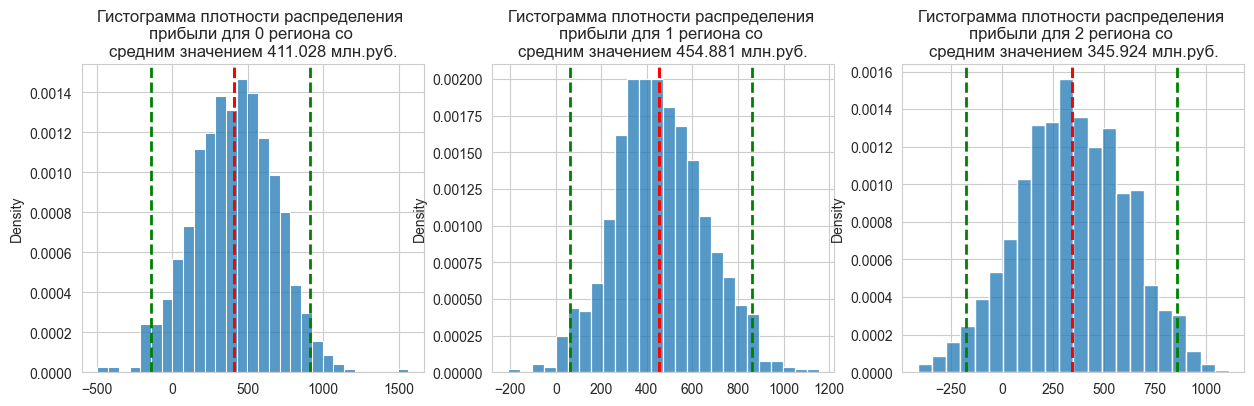

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
for i, lst in enumerate([mean_revenues_0, mean_revenues_1 ,mean_revenues_2]):
    mean_value = round(np.mean(lst), 3)
    axs[i].set_title(f'Гистограмма плотности распределения \nприбыли для {i} региона со \nсредним значением {mean_value} млн.руб.')
    sns.histplot(data=lst, ax=axs[i],  stat='density', common_norm=True)
    axs[i].axvline(x=mean_value, color='red', linestyle='--', linewidth=2)
    first_line = np.percentile(lst, 2.5)
    second_line = np.percentile(lst, 97.5)
    axs[i].axvline(x=mean_value, color='red', linestyle='--', linewidth=2)
    axs[i].axvline(x=first_line, color='green', linestyle='--', linewidth=2)
    axs[i].axvline(x=second_line, color='green', linestyle='--', linewidth=2)
    
plt.show()

Доверительный интервал для региона описанного данными из таблицы geo_data_0:

In [21]:
for number, lst in {0: mean_revenues_0, 1:mean_revenues_1, 2:mean_revenues_2}.items():
    print(f'Информация по региону №{number}')
    print(f'Вероятность получить убыток в регионе {stats.percentileofscore(lst, 0):.1f}%')
    print(f'Средняя доходность от 200 скважин - {np.mean(lst):.3f} млн.руб')    
    print(f'Доверительный интервал прибыли в 95% варьируется от {np.percentile(lst, 2.5):.3f} млн.руб до {np.percentile(lst, 97.5):.3f} млн.руб')
    
    print('\n')

Информация по региону №0
Вероятность получить убыток в регионе 6.5%
Средняя доходность от 200 скважин - 411.028 млн.руб
Доверительный интервал прибыли в 95% варьируется от -136.848 млн.руб до 908.967 млн.руб


Информация по региону №1
Вероятность получить убыток в регионе 0.6%
Средняя доходность от 200 скважин - 454.881 млн.руб
Доверительный интервал прибыли в 95% варьируется от 60.940 млн.руб до 862.952 млн.руб


Информация по региону №2
Вероятность получить убыток в регионе 10.0%
Средняя доходность от 200 скважин - 345.924 млн.руб
Доверительный интервал прибыли в 95% варьируется от -174.216 млн.руб до 859.397 млн.руб




Наименьшая вероятность полуить убыток оказалась в регионе с номером **1** - всего **0,6%**. Я связываю это с высокой предсказательной способностью модели, обученной на данных из этого региона. Да, средняя производительность скважин была самая низкая, но высокая точность помогла отбирать действительно только самые производительные скважины (это видно по большей плотности гистограммы в районе среднего значения). 

В подтверждение вышесказанного можно отметить, что порядок ТОП'а моделей по величине средней прибыли аналогичен ТОП'у по предсказательной способности (1 место - 1 регион, 2 место - 0 регион, 3 место - 2 регион). Регион 2 имел самую большую среднюю доходность и самое плохое качество модели.

## Вывод:

В ходе данной работы были исследованы данные из трех регионов с целью найти тот, в котором добыча принесет наибольшую прибыль. 

После загрузки данных и предварительного знакомства не было выявлено пропусков и явных дубликатов в данных. Обнаружены дублирующиеся скважины в разных регионах. Ввиду невозможности обнаружения правдивого региона и небольшого количества значений относительно общего их числа, такие скважины были удалены из всех таблиц. 

Обнаружена сильная линейная зависимость между входным признаком f2 и целевым product в таблице geo_data_1, также эти признаки были распределены практически дискретно.

В ходе обучения моделей линейной регрессии, естественно, наилучшее значение метрик показала модель на данных региона 1, однако средняя производительность скважин в данном регионе оставалсь меньше других.

После анализа доверительных интервалов прибыли, полученной с помощью метода Bootstrap был выбран 1 регион в качестве основного к рекомендации заказчику, так как у него наименьшая вероятность получения убытка в **0,6%**. Доверительный в **95%** интервал составил от **60.940 млн.руб** до **862.952 млн.руб**. Средняя доходность от 200 скважин - **454.881 млн.руб**.